# Assignment 1 Report
### Authors: Sebastian Mendoza and Logan Long

### Installations

In [242]:
!pip install pandas
!pip install optuna #For accessing to different distributions and other methods
!pip install optuna-integration #For accesing to optuna.integration.OptunaSearchCV and enabling integration with Scikit-Learn


### Imports

In [302]:
# Core data manipulation and analysis
import numpy as np
import pandas as pd
import pickle
import os
from scipy.stats import randint, uniform
from scipy import stats
import time
from datetime import datetime
import pprint
# Visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import ConfusionMatrixDisplay
from IPython.display import display, HTML

# Scikit-learn imports
#Model Selections & Eval
from sklearn.model_selection import (
    train_test_split,
    KFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
## Preprocessing and pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
## Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# Optuna optimization
import optuna
from optuna.distributions import (
    IntDistribution as IntDist,
    CategoricalDistribution as CatDist
)
from optuna.integration import OptunaSearchCV
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances
)
# Configure Optuna logging
optuna.logging.set_verbosity(optuna.logging.ERROR)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Global Vars

In [244]:
fitted_pipelines = {
    "Decision Tree": None,
    "DT_Optimized": None,
    "KNN": None,
    "KNN_Optimized": None,
    "Logistic Regression": None,
    "SVM": None,
    "SVM_optuna": None,
    "RF": None,
    "RF_optuna": None,
    "GB": None,
    "GB_optuna": None,
    "Dummy": None
}

execution_times = {}

all_model_accuracies = {}

confidence_invervals = {}

best_results_basic_models_for_test_size = {}


# 1. SIMPLIFIED EDA

## Load Data Set and Get Basic Info

In [245]:
# Load the .pkl file (assuming it contains a DataFrame)
df = pd.read_pickle('/content/sample_data/attrition_available_11.pkl')

# Basic info
print(f"Number of instances (rows): {df.shape[0]}")
print(f"Number of features (columns): {df.shape[1]}")
df.info()



Number of instances (rows): 1426
Number of features (columns): 31
<class 'pandas.core.frame.DataFrame'>
Index: 1426 entries, 1 to 977
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      1426 non-null   float64
 1   absences                 1426 non-null   int64  
 2   JobInvolvement           1426 non-null   int64  
 3   PerformanceRating        1426 non-null   int64  
 4   EnvironmentSatisfaction  1419 non-null   float64
 5   JobSatisfaction          1420 non-null   float64
 6   WorkLifeBalance          1273 non-null   float64
 7   Age                      1426 non-null   int64  
 8   Attrition                1426 non-null   object 
 9   BusinessTravel           1426 non-null   object 
 10  Department               1426 non-null   object 
 11  DistanceFromHome         1426 non-null   int64  
 12  Education                1426 non-null   int64  
 13  EducationField    

## Identify Categorical and Numerical Variable


In [246]:
# Separate features by type
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(include=['number']).columns

print(f"Categorical features ({len(categorical_features)}): {list(categorical_features)}")
print(f"Numerical features ({len(numerical_features)}): {list(numerical_features)}")


Categorical features (8): ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18']
Numerical features (23): ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


## Check for High Cardinality in Categorical Features


In [247]:
# Check cardinality of categorical features
high_cardinality = {col: df[col].nunique() for col in categorical_features if df[col].nunique() > 3}  # Arbitrary threshold of 10
print("Categorical features with high cardinality (more than 10 unique values):")
for col, unique_count in high_cardinality.items():
    print(f"{col}: {unique_count} unique values")

Categorical features with high cardinality (more than 10 unique values):
EducationField: 6 unique values
JobRole: 9 unique values


## Identify Missing Values

In [248]:
# Check for missing values
missing_values = df.isnull().sum()
missing_features = missing_values[missing_values > 0]
print("Features with missing values:")
print(missing_features)

Features with missing values:
EnvironmentSatisfaction      7
JobSatisfaction              6
WorkLifeBalance            153
EmployeeID                 130
NumCompaniesWorked         149
TotalWorkingYears            3
dtype: int64


## Check for Constant Columns

In [249]:
# Identify constant columns
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print("Constant columns:", constant_columns)

Constant columns: ['EmployeeCount', 'Over18', 'StandardHours']


## Determine Problem Type (Regression or Classification) and Class Imbalance



In [250]:
# Assuming the target column is named 'target'. Replace with actual column name if different.
target_col = 'Attrition'

# Check if the target is categorical (classification) or numerical (regression)
if df[target_col].dtype in ['object', 'category']:
    print("It is a classification problem.")
    print("Class distribution:")
    print(df[target_col].value_counts())
else:
    print("It is a regression problem.")

It is a classification problem.
Class distribution:
Attrition
No     715
Yes    711
Name: count, dtype: int64


## Summary

We have three constant columns. We can eliminate these from our analysis to reduce dimensionality since they will add basically no information or value to our model. These attributes are:
- EmployeeCount
- Over18
- StandardHours

A few attributes have high cardinality (defined by those with more than 3 categories). These are:
-

There are a few columns with missing values. These will require some type of pipeline with imputation. These are:
- EnvironmentSatisfaction (Numerical)
- JobSatisfaction         (Numerical)
- WorkLifeBalance         (Numerical)
- EmployeeID              (Numerical) -> Might be able to get rid of
- NumCompaniesWorked      (Numerical)
- TotalWorkingYears       (Numerical)

After removing constant columns, there will be 6 categorical attributes and 21 numerical attributes. The target value is Attrition which has "Yes" or "No" values.

Attrition is our target, so this is a 2-class classification problem. There are 715 No's and 711 Yes' in our dataset, this is quite balanced.

In [251]:
# Extras


# 2. BASIC METHODS: TREES, KNN, AND LOGISTIC REGRESSION

### Helper Plotting

In [252]:
#Helper Plotting
#Helper Functions Plotting


# Function to plot confusion matrix
def plot_confusion_matrix(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


# Function to plot feature importances for tree-based models
def plot_feature_importances(pipeline, model_name):
    # Get the final step model (after preprocessing)
    model = pipeline.named_steps['classifier']

    # Get feature names from the pipeline
    cat_features = list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features))
    feature_names = numerical_features + cat_features

    # Plot feature importances (only for tree-based models)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(importances)), importances[indices], align='center')
    plt.yticks(range(len(importances)), np.array(feature_names)[indices])
    plt.xlabel("Feature Importance")
    plt.title(f"{model_name} Feature Importances")
    plt.gca().invert_yaxis()
    plt.show()


### Helper Function

In [253]:
def get_accuracy_on_test(model):
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  # print(f"Accuracy on fit: {acc}")
  return acc

def train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test, to_print=False, add_time_to_global_flag=False):
  pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

  start_time = time.time()
  timestamp = datetime.now()

  pipe.fit(X_train,y_train)

  execution_time = time.time() - start_time

  if to_print:
    print("Model took", execution_time, "to fit")
  execution_times[name] = execution_time

  acc = get_accuracy_on_test(pipe)

  fitted_pipelines[name] = pipe
  return acc

def make_table(dataframe, title):
  # Display the table with styling

  styled_df = dataframe.style\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'caption', 'props': [('caption-side', 'top')]}
    ])\
    .set_caption(title)\
    .hide(axis='index')

  display(styled_df)


## Split Data into Test and Training Sets

In [300]:
# Split the data (assuming target column is 'Attrition' + Constant Columns)
X = df.drop(columns=['Attrition', 'EmployeeCount', 'Over18', 'StandardHours'])
y = df['Attrition']

# Encode target as binary
y = y.map({'Yes': 1, 'No': 0})

# Assuming X and y are the features and labels prepared in Part 1
test_size = 0.33
random_state = 100545282  # Sebastian's Student Number

# Initial 2/3, 1/3 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 955
Test set size: 471


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Preprocessing
We implement a pipeline to process the data for numerical and categorical featires.

For the **numercial attributes**: we use the "mean" value to fill in missing values. As well, we implement a standard scaler.

For **categorical values**, we use a "most_frequent" imputer and a OneHotEncoder


In [255]:
# Define categorical and numerical columns (after removing constant columns)
categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
numerical_features = ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction',
                      'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeID',
                      'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears',
                      'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())                  # Standardize features
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with mode
    ('encoder', OneHotEncoder(handle_unknown='ignore'))    # One-hot encode categorical variables
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## Train & Evaluate Basic Models
Now we will train a very basic model with default parameters. The initial test size will be a 66/33 training/testing split. This allocates a majority of the data to make our model better while being able to assess how our model generalizes.

In [256]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=random_state),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=random_state)
}

# Train, evaluate and compare models
for name, model in models.items():
    acc = train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test)

## Try some other test size values

In [257]:
possible_test_sizes = list(np.arange(0.05, 0.55, 0.05))
best_results_basic_models_for_test_size ={}
for size in possible_test_sizes:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=random_state)
  for name, model in models.items():
    metric = train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test)
    if name not in best_results_basic_models_for_test_size or metric > best_results_basic_models_for_test_size[name]['score']:
      best_results_basic_models_for_test_size[name] = {'size': size, 'score': metric}

def table_for_best_results_basic_models_for_test_size():
  # Convert nested dict to DataFrame
  res = pd.DataFrame.from_dict(best_results_basic_models_for_test_size, orient='index')
  res = res.reset_index()
  res.columns = ['Model', 'Score', 'Size']
  res['Size'] = res['Size'].map('{:.3}'.format)
  res['Score'] = res['Score'].map('{:.2%}'.format)

  make_table(res, "Model Performance Comparison")

table_for_best_results_basic_models_for_test_size()


Model,Score,Size
Decision Tree,25.00%,0.882
KNN,30.00%,0.738
Logistic Regression,5.00%,0.792


We see that values around 0.25 to 0.3 will give us the best results for the default models. Since there 1426 entries, that would give us between 356 and 427 entries to test with.

0.25 seems like a good test size. This will allow u also allocating more data to improve the model while leaving plenty of entries to evaluate generalization. Going forward we will follow a 75/25 train/testing split.

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
best_results_basic_models_for_test_size ={} # Need to clear it here
for name, model in models.items():
  acc = train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test, add_time_to_global_flag=True)
  if name not in best_results_basic_models_for_test_size or acc > best_results_basic_models_for_test_size[name]:
    best_results_basic_models_for_test_size[name] = acc
  all_model_accuracies[name] = acc


def another_table_for_best_results_basic_models_for_test_size():
  # Convert nested dict to DataFrame
  res = pd.DataFrame.from_dict(best_results_basic_models_for_test_size, orient='index')
  res = res.reset_index()
  res.columns = ['Model', 'Score']
  res['Score'] = res['Score'].map('{:.2%}'.format)

  make_table(res, "Model Acc For Size 0.25")

another_table_for_best_results_basic_models_for_test_size()


Model,Score
Decision Tree,88.24%
KNN,73.39%
Logistic Regression,74.51%


## Compare Against a Dummy Model

In [292]:
from sklearn.dummy import DummyClassifier

# Dummy classifier to predict the most frequent class
dummy_acc = train_and_evaluate_model("Dummy", DummyClassifier(strategy='most_frequent'), X_train, y_train, X_test, y_test)
all_model_accuracies["Dummy"] = dummy_acc

# Create dictionary with results
results_dict = {
    'Model': ['Decision Tree', 'KNN', 'Logistic Regression', 'Dummy Classifier'],
    'Accuracy': [
        best_results_basic_models_for_test_size["Decision Tree"],
        best_results_basic_models_for_test_size["KNN"],
        best_results_basic_models_for_test_size["Logistic Regression"],
        dummy_acc
    ]
}

# Calculate accuracy ratios
results_dict['Ratio vs Dummy'] = [
    best_results_basic_models_for_test_size["Decision Tree"] / dummy_acc,
    best_results_basic_models_for_test_size["KNN"] / dummy_acc,
    best_results_basic_models_for_test_size["Logistic Regression"] / dummy_acc,
    1.0  # Dummy vs itself = 1
]

# Create DataFrame
results_df = pd.DataFrame(results_dict)

# Format the numeric columns
results_df['Accuracy'] = results_df['Accuracy'].map('{:.3f}'.format)
results_df['Ratio vs Dummy'] = results_df['Ratio vs Dummy'].map('{:.2f}'.format)

make_table(results_df, "Model Perf. Against Dummy")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model,Accuracy,Ratio vs Dummy
Decision Tree,0.882,1.83
KNN,0.734,1.52
Logistic Regression,0.745,1.55
Dummy Classifier,0.482,1.00


It's clear to see that the dummy model's best accuracy is 48.2% while the minimum basic model has an accuracy of 73.4%. We can guarentee the basic models are better performant that the Dummy Classifier

## Plotting With ChatGPT
For convience and time, ChatGPT was consulted to help generate the code to make these plots. The query was: "Generate code to plot valuable metrics that compare the performance of a Decision Tree, KNN model, Logistic Regression model and how they compare and metrics within"


In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set style for better visualization
plt.style.use('seaborn-v0_8')

# 1. Model Performance Comparison
def plot_model_accuracies():
    accuracies = {
        'Decision Tree': 0.8824,  # Replace with your actual values
        'KNN': 0.7339,
        'Logistic Regression': 0.7451,
        'Dummy': 0.4818
    }

    plt.figure(figsize=(7.5, 4.5))
    bars = plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy Score')

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    plt.ylim(0, 1.0)  # Set y-axis from 0 to 1
    plt.show()

# 2. Feature Distribution by Attrition
def plot_numerical_distributions(df, features=['Age', 'MonthlyIncome', 'YearsAtCompany']):
    fig, axes = plt.subplots(len(features), 1, figsize=(10, 3*len(features)))

    for i, feature in enumerate(features):
        sns.histplot(data=df, x=feature, hue='Attrition', multiple="layer", ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by Attrition Status')

    plt.tight_layout()
    plt.show()

# 3. Correlation Heatmap
def plot_correlation_heatmap(df):
    # Select only numerical columns
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    plt.figure(figsize=(12, 10))
    correlation_matrix = numerical_df.corr()

    # Create heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap of Numerical Features')
    plt.tight_layout()
    plt.show()

# 4. Feature Importance Plot (for Decision Tree)
def plot_feature_importance(pipeline, feature_names):
    importances = pipeline.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5.5))
    plt.title("Feature Importances (Decision Tree)")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 5. Box Plots for Key Features
def plot_boxplots(df, features=['Age', 'MonthlyIncome', 'YearsAtCompany']):
    fig, axes = plt.subplots(1, len(features), figsize=(6*len(features), 6))  # 1 row, multiple columns

    for i, feature in enumerate(features):
        sns.boxplot(data=df, x='Attrition', y=feature, ax=axes[i])
        axes[i].set_title(f'{feature} Distribution by Attrition Status')

    plt.tight_layout()
    plt.show()

# 6. Categorical Features Distribution
def plot_categorical_distributions(df, features=['Department', 'JobRole', 'MaritalStatus']):
    fig, axes = plt.subplots(1, len(features), figsize=(5*len(features), 6))

    for i, feature in enumerate(features):
        attrition_proportions = pd.crosstab(df[feature], df['Attrition'], normalize='index')
        attrition_proportions.plot(kind='bar', stacked=True, ax=axes[i])
        axes[i].set_title(f'Attrition Rate by {feature}')
        axes[i].legend_.remove()  # Remove legends from each subplot

    # Add a single legend for the entire plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    plt.tight_layout()
    plt.show()

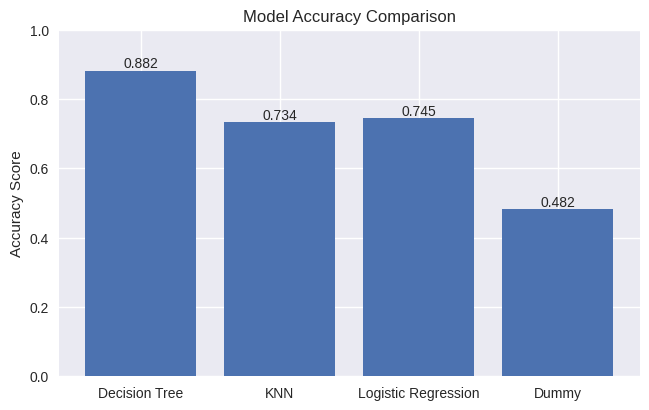

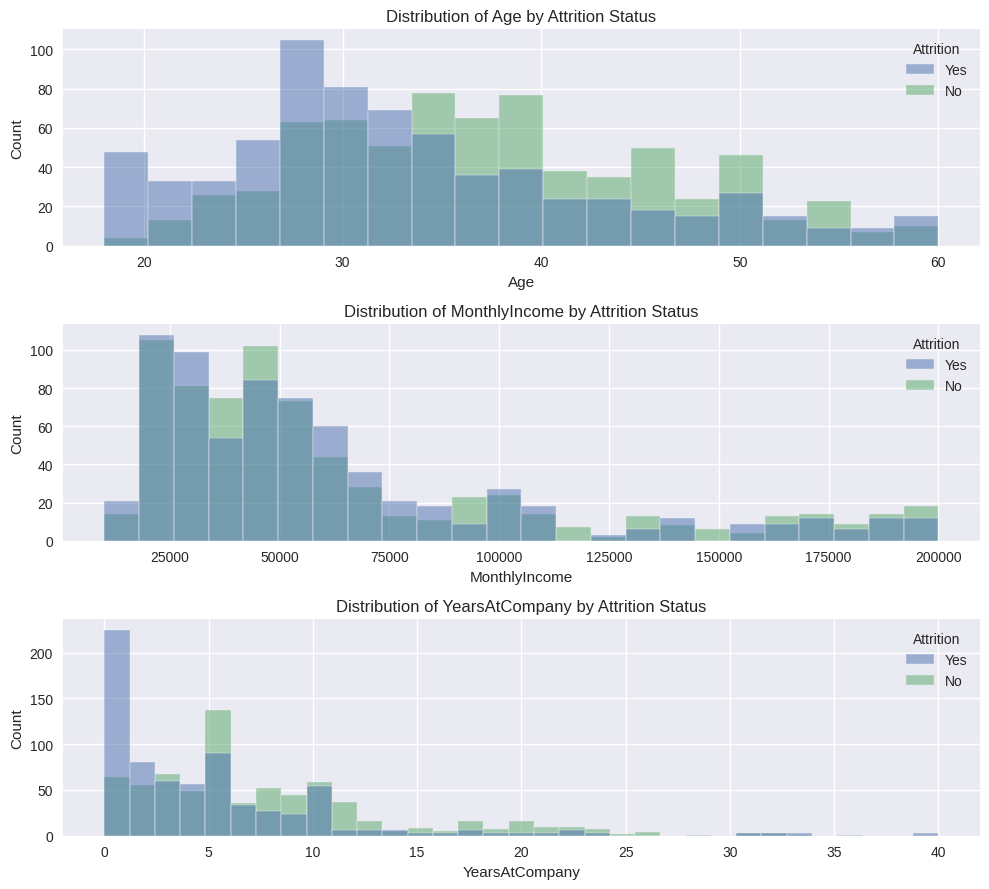

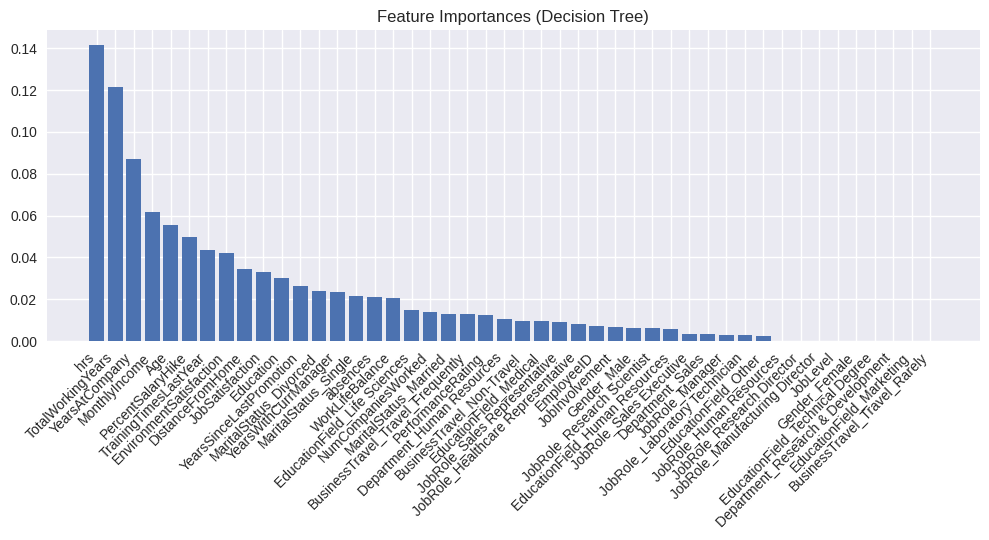

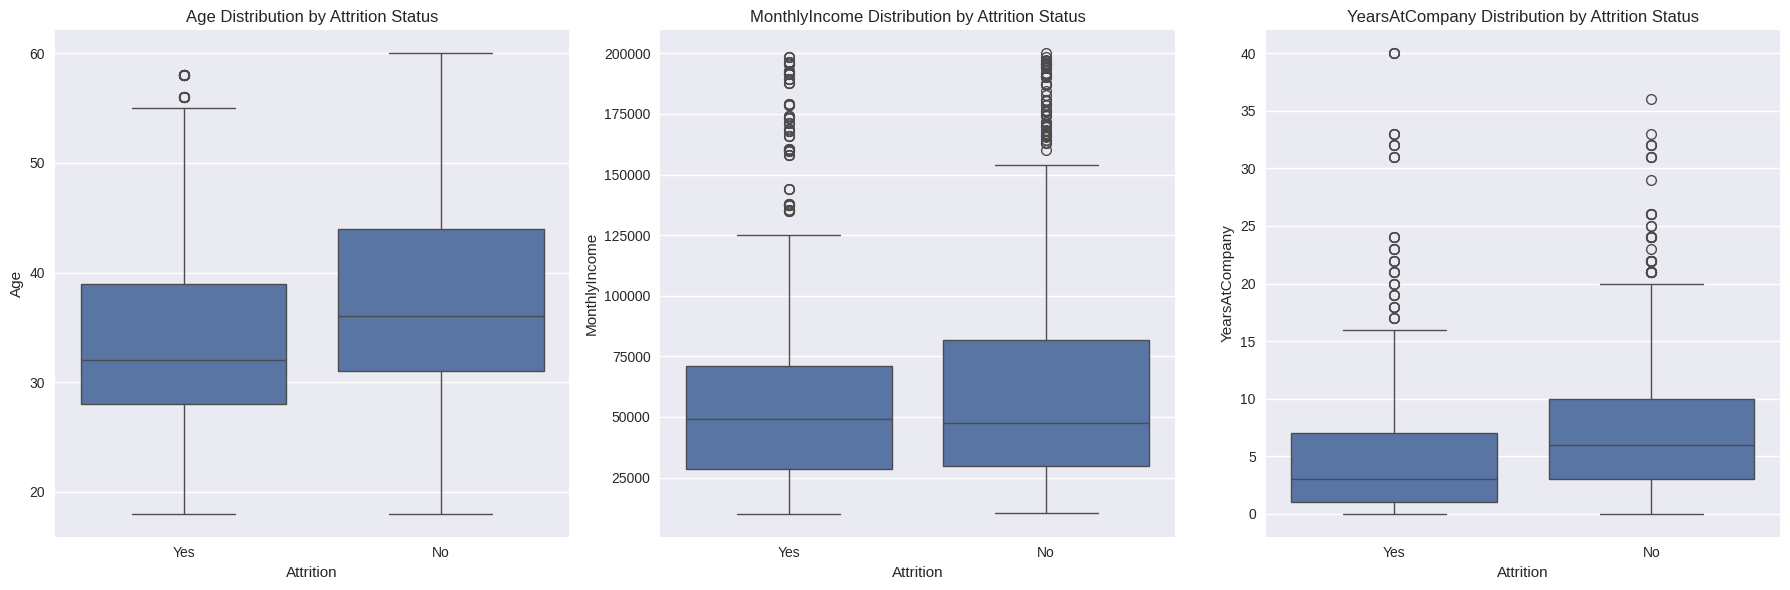

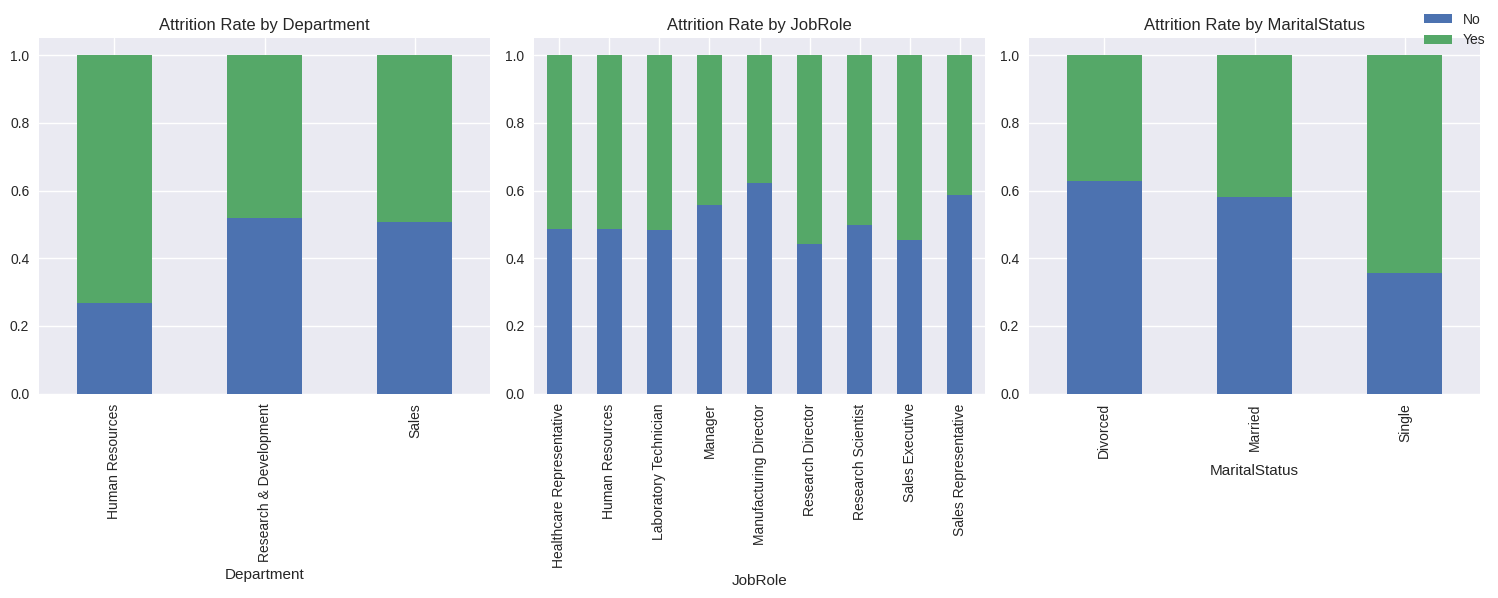

In [261]:
# Generate all visualizations
plot_model_accuracies()

# Feature distributions
plot_numerical_distributions(df)

# Correlation heatmap
# plot_correlation_heatmap(df)

# Feature importance for Decision Tree
# Can only do feature importance for a decisaion treee
feature_names = (numerical_features +
                list(fitted_pipelines["Decision Tree"].named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['encoder']
                     .get_feature_names_out(categorical_features)))
plot_feature_importance(fitted_pipelines["Decision Tree"], feature_names)

# # Box plots of
plot_boxplots(df)

# # Categorical distributions
plot_categorical_distributions(df)

### Some Valuable Insights:
- The Decision Tree is the most accurate. However, this may be due to overfitting since DT's can overfit with such small datasets,
- From the distribution graphs, the attrition rate be higher for younger employees and lower for older employees. Attrition rate is much more even for monthly income
- When looking at feature importance, hrs, TotalWorkingYears, and YearsAtCompany are the most important. Many featuress are not that important including all the features made by the category encodings, EmployeeID, and Gender.
- From the boxplots, people with more years at the company seem to No more often.
- From the bar charts, HR department leaves the most. Job role doesn't seem to have that large of a factor in attrition rate.

Note: for convience and time, ChatGPT was consulted to help generate the code to make these plots. The query was: "Generate code to plot the performance of each model and how they compare to each other. I want to learn about model perfomance here"


In [266]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.model_selection import learning_curve

def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))

    for name, pipeline in models.items():
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Random prediction line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_learning_curves(models, X, y):
    fig, axes = plt.subplots(1, len(models), figsize=(20, 5))

    train_sizes = np.linspace(0.1, 1.0, 5)

    for idx, (name, pipeline) in enumerate(models.items()):
        train_sizes, train_scores, test_scores = learning_curve(
            pipeline, X, y,
            train_sizes=train_sizes,
            cv=5, n_jobs=-1, scoring='accuracy'
        )

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        axes[idx].plot(train_sizes, train_mean, label='Training score')
        axes[idx].plot(train_sizes, test_mean, label='Cross-validation score')

        axes[idx].fill_between(train_sizes, train_mean - train_std,
                             train_mean + train_std, alpha=0.1)
        axes[idx].fill_between(train_sizes, test_mean - test_std,
                             test_mean + test_std, alpha=0.1)

        axes[idx].set_title(f'Learning Curve ({name})')
        axes[idx].set_xlabel('Training Examples')
        axes[idx].set_ylabel('Accuracy Score')
        axes[idx].grid(True)
        axes[idx].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(models, X_test, y_test):
    fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

    for idx, (name, pipeline) in enumerate(models.items()):
        y_pred = pipeline.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'Confusion Matrix\n{name}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

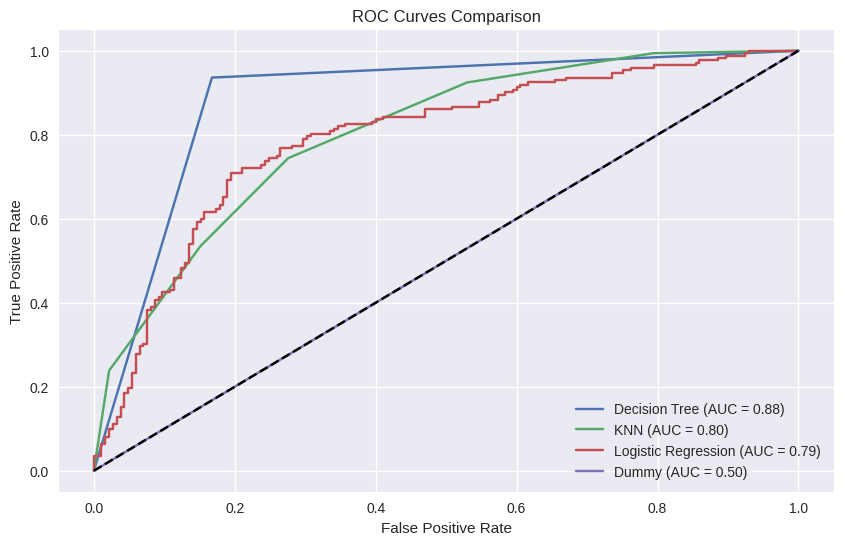

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

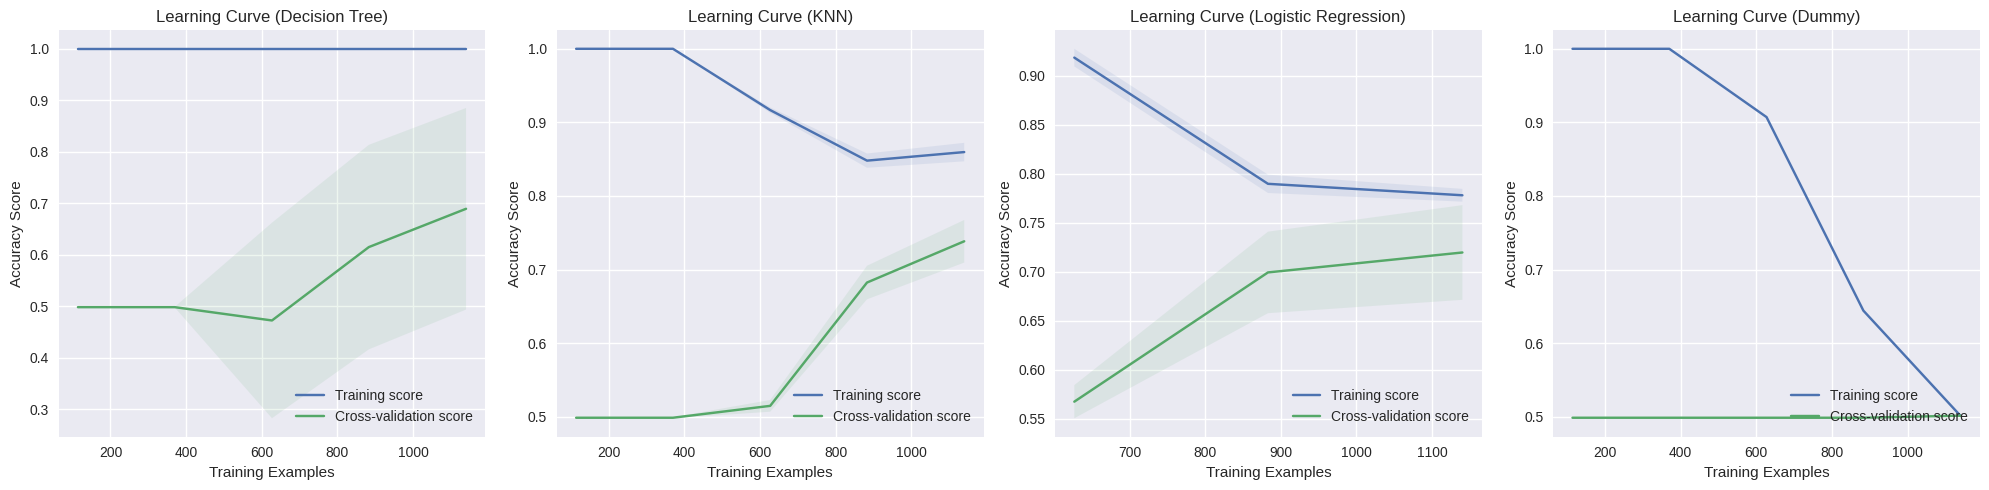

IndexError: index 3 is out of bounds for axis 0 with size 3

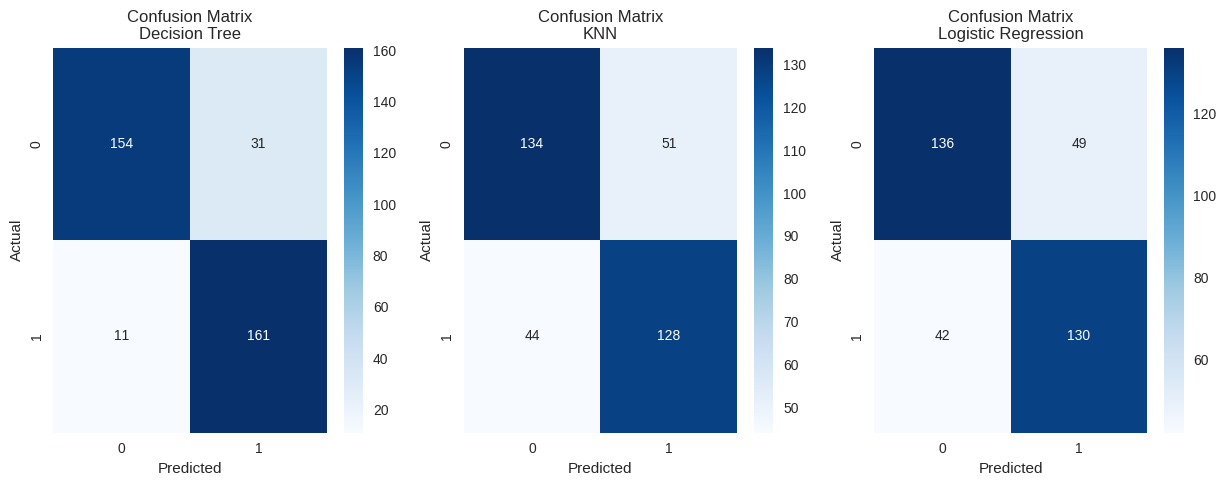

In [267]:
# # Now generate the plots
basic_pipes = {key: value for key, value in fitted_pipelines.items() if value is not None}
plot_roc_curves(basic_pipes, X_test, y_test)
plot_learning_curves(basic_pipes, X, y)
plot_confusion_matrices(basic_pipes, X_test, y_test)

### Insights
- Our decision tree has the best True Positive Rate and they are all better than the Dumym model which is the black dotted line. KNN and LR are basically neck-in-neck
- The most valuable plots are the learning curve. This curve shows the training score vs the score on the test set as the number of training samples increase. So looking to the right of the plot, there is more data used for training. The LR seems to be converging with to some point at 0.75. The KNN has not converged well looks to be in a trajectory towards 0.80. The decision tree is not converging as the test score is much worse than the training score, this is evidence of overfitting. The model is not generalizing well on these default hyperparameters.
- The Confusion matrix provides some nice insight into the True positive and True Negative counts.

# 3. HYPER-PARAMETER OPTIMIZATION/TUNING

Let's first work on GridSearch for the Decision Tree and the KNN. Although the
logistic regression had a slightly better performance, from the learning curve diagram, we will use the KNN instead of the LR model because it's looks to be converging at a higher accuracy value than the LR model. So we assume that the KNN will be better than the LR if given more data. Our Decision tree is overfitting a lot so hopefully the hyperparameter tuning will allow us to correct for this by decreasing complexity.

In [268]:
#Reusable Plotting
def create_search_comparison_table(model_results, title):
    # Prepare data for table
    data = []

    for model_name, results in model_results.items():
        row = {
            'Model': model_name,
            'Best CV Score': results['cv_score'],
            'Test Score': results['test_score'],
            'Best Parameters': str(results['best_params'])
        }
        data.append(row)

    # Create DataFrame
    df = pd.DataFrame(data)

    # Format scores as percentages
    df['Best CV Score'] = df['Best CV Score'].map('{:.1%}'.format)
    df['Test Score'] = df['Test Score'].map('{:.1%}'.format)

    # Style the DataFrame
    styled_df = df.style\
        .set_properties(**{
            'text-align': 'center',
            'white-space': 'pre-wrap'
        })\
        .set_table_styles([
            {'selector': 'th',
             'props': [('text-align', 'center'),
                      ('font-weight', 'bold'),
                      ('background-color', '#615e5e')]},
            {'selector': 'caption',
             'props': [('caption-side', 'top')]},
            {'selector': 'td',
             'props': [('max-width', '400px'),
                      ('white-space', 'pre-wrap')]},
        ])\
        .set_caption(title)\
        .hide(axis='index')

    return styled_df

## Grid Search

In [269]:
# 1. Decision Tree Grid Search
dt_param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': [3,5,7,10,15,20, None]
}
inner = KFold(n_splits=3, shuffle=True, random_state=random_state)

dt_grid_search = GridSearchCV(
    fitted_pipelines["Decision Tree"],
    dt_param_grid,
    cv=inner,  # 3-fold cross validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
)

# Fit Decision Tree Grid Search
dt_grid_search.fit(X_train, y_train)

# 2. KNN Grid Search
knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan'],
}

knn_grid_search = GridSearchCV(
    fitted_pipelines["KNN"],
    knn_param_grid,
    cv=inner,  # 3-fold cross validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
)

# Fit KNN Grid Search
knn_grid_search.fit(X_train, y_train)

# Store the best models for later use
best_dt_grid = dt_grid_search.best_estimator_
best_knn_grid = knn_grid_search.best_estimator_


# Prepare the results dictionary
grid_search_results = {
    'Decision Tree': {
        'best_params': dt_grid_search.best_params_,
        'cv_score': dt_grid_search.best_score_,
        'test_score': dt_grid_search.score(X_test, y_test)
    },
    'KNN': {
        'best_params': knn_grid_search.best_params_,
        'cv_score': knn_grid_search.best_score_,
        'test_score': knn_grid_search.score(X_test, y_test)
    }
}

# Display the comparison table
display(create_search_comparison_table(grid_search_results, "Grid Search Comparison Table"))

Fitting 3 folds for each of 1568 candidates, totalling 4704 fits
Fitting 3 folds for each of 28 candidates, totalling 84 fits


Model,Best CV Score,Test Score,Best Parameters
Decision Tree,81.0%,82.4%,"{'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__max_features': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}"
KNN,82.0%,85.4%,"{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}"


## Random Search

Now for the Randomized Search

In [270]:
# 1. Decision Tree Random Search
# Using broader distributions for parameters
dt_param_dist = {
    'classifier__max_depth': randint(1, 30),
    'classifier__min_samples_split': randint(2, 30),
    'classifier__min_samples_leaf': randint(1, 15),
    'classifier__criterion': ['gini', 'entropy']
}
inner = KFold(n_splits=3, shuffle=True, random_state=random_state)

budget = 15
dt_random_search = RandomizedSearchCV(
    fitted_pipelines["Decision Tree"],
    dt_param_dist,
    n_iter=budget,  # Number of parameter settings sampled
    cv=inner,  # 3-fold cross validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
)

# Fit Decision Tree Random Search
dt_random_search.fit(X_train, y_train)

# 2. KNN Random Search
knn_param_dist = {
    'classifier__n_neighbors': randint(1, 20),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': randint(1, 4)  # Only used for minkowski metric
}

budget = 15
knn_random_search = RandomizedSearchCV(
    fitted_pipelines["KNN"],
    knn_param_dist,
    n_iter=budget,  # Number of parameter settings sampled
    cv=inner,  # 3-fold cross validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
)

# Fit KNN Random Search
knn_random_search.fit(X_train, y_train)

# Store the best models for later use
best_dt_random = dt_random_search.best_estimator_
best_knn_random = knn_random_search.best_estimator_

# Prepare the results dictionary
random_search_results = {
    'Decision Tree': {
        'best_params': dt_random_search.best_params_,
        'cv_score': dt_random_search.best_score_,
        'test_score': dt_random_search.score(X_test, y_test)
    },
    'KNN': {
        'best_params': knn_random_search.best_params_,
        'cv_score': knn_random_search.best_score_,
        'test_score': knn_random_search.score(X_test, y_test)
    }
}
display(create_search_comparison_table(random_search_results, "Random Search Comparison Table"))

# # Compare all search results
# print("\nComparison of All Searches:")
# print("Decision Tree:")
# print(f"Top {min(5, len(dt_random_search.cv_results_['mean_test_score']))} parameter combinations:")
# dt_arr = sorted(zip(dt_grid_search.cv_results_['mean_test_score'], dt_grid_search.cv_results_['params']), key=lambda x: x[0], reverse=True)[:5]
# print(dt_arr)
# for mean_score, params in dt_arr:
#     print(f"Mean CV score: {mean_score:.4f} with params: {params}")

# print("\nKNN:")
# print(f"Top {min(5, len(knn_random_search.cv_results_['mean_test_score']))} parameter combinations:")
# knn_arr = sorted(zip(knn_random_search.cv_results_['mean_test_score'], knn_random_search.cv_results_['params']),  key=lambda x: x[0], reverse=True)[:5]
# for mean_score, params in knn_arr:
#     print(f"Mean CV score: {mean_score:.4f} with params: {params}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits


Model,Best CV Score,Test Score,Best Parameters
Decision Tree,71.9%,78.4%,"{'classifier__criterion': 'gini', 'classifier__max_depth': 11, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 7}"
KNN,81.8%,86.3%,"{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'distance'}"


## Bayesian (Optuna)

In [293]:
# Search space with integer uniform distributions
dt_param_grid_optuna = {
    'classifier__max_depth': IntDist(2, 35),
    'classifier__min_samples_split': IntDist(2, 15),
    'classifier__min_samples_leaf': IntDist(1, 15),
    'classifier__criterion': CatDist(['gini', 'entropy'])
}

inner = KFold(n_splits=6, shuffle=True, random_state=random_state)
budget = 75
dt_optuna = optuna.integration.OptunaSearchCV(fitted_pipelines["Decision Tree"],
 dt_param_grid_optuna,
 scoring='accuracy',
 n_trials=budget,
 cv=inner,
 n_jobs=-1,
 verbose=0,
 timeout=600,
 random_state=random_state,
#  refit=True
 )

start_time = time.time()
timestamp = datetime.now()
dt_optuna.fit(X_train, y_train)
execution_time = time.time() - start_time
execution_times["DT_Optimized"] = execution_time


# At this point, regr_optuna contains the model with the best hyper-parameters found by OptunaSearchCV
# and trained on the complete X_train

# KNN
knn_param_grid_optuna = {
    'classifier__n_neighbors': IntDist(1, 20),
    'classifier__weights': CatDist(['uniform', 'distance']),
    'classifier__metric': CatDist(['euclidean', 'manhattan', 'minkowski']),
    'classifier__p': IntDist(1, 4)  # Only used for minkowski metric
}
budget = 75
knn_optuna = optuna.integration.OptunaSearchCV(fitted_pipelines["KNN"],
 knn_param_grid_optuna,
 scoring='accuracy',
 n_trials=budget,
 cv=inner,
 n_jobs=-1,
 verbose=0,
 timeout=600,
 random_state=random_state,
#  refit=True
 )
start_time = time.time()
timestamp = datetime.now()
knn_optuna.fit(X_train, y_train)
execution_time = time.time() - start_time
execution_times["KNN_Optimized"] = execution_time

optuna_search_results = {
    'Decision Tree': {
        'best_params': dt_optuna.best_params_,
        'cv_score': dt_optuna.best_score_,
        'test_score': dt_optuna.score(X_test, y_test)
    },
    'KNN': {
        'best_params': knn_optuna.best_params_,
        'cv_score': knn_optuna.best_score_,
        'test_score': knn_optuna.score(X_test, y_test)
    }
}
display(create_search_comparison_table(random_search_results, "Random Search Comparison Table"))


# Add Models to collection
fitted_pipelines["DT_Optimized"] = dt_optuna
fitted_pipelines["KNN_Optimized"] = knn_optuna
optimized_dt_optuna_acc = get_accuracy_on_test(dt_optuna)
optimized_knn_optuna_acc = get_accuracy_on_test(knn_optuna)
all_model_accuracies["DT_Optimized"] = optimized_dt_optuna_acc
all_model_accuracies["KNN_Optimized"] = optimized_knn_optuna_acc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-293-4a8bdc745ecd>:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  dt_optuna = optuna.integration.OptunaSearchCV(fitted_pipelines["Decision Tree"],
<ipython-input-293-4a8bdc745ecd>:41: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  knn_optuna = optuna.integration.OptunaSearchCV(fitted_pipelines["KNN"],


Model,Best CV Score,Test Score,Best Parameters
Decision Tree,71.9%,78.4%,"{'classifier__criterion': 'gini', 'classifier__max_depth': 11, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 7}"
KNN,81.8%,86.3%,"{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'distance'}"


<ipython-input-272-2593032fb9bc>:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(dt_study)


<Figure size 1000x500 with 0 Axes>

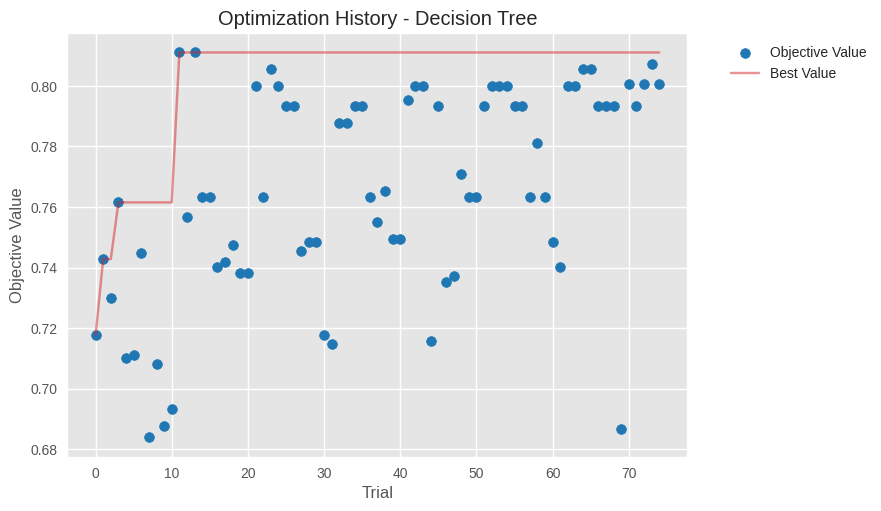

<ipython-input-272-2593032fb9bc>:13: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(knn_study)


<Figure size 1000x500 with 0 Axes>

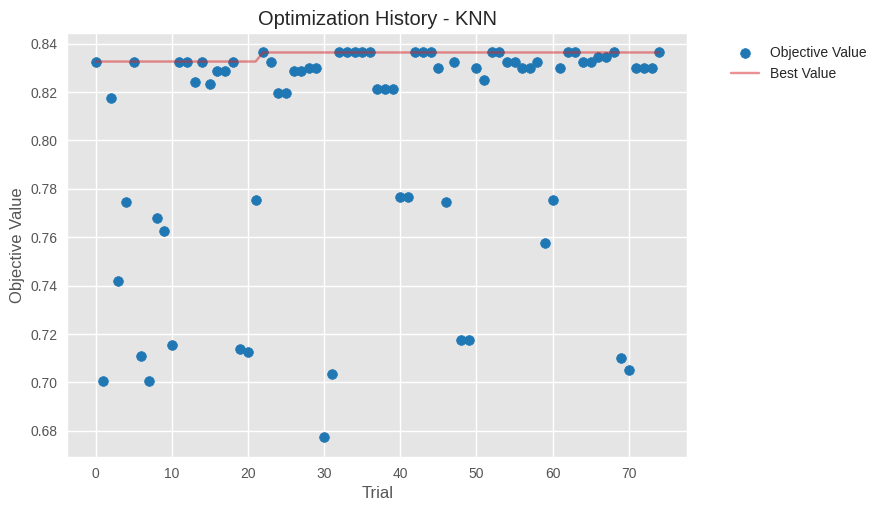

<ipython-input-272-2593032fb9bc>:21: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(dt_study)


<Figure size 1000x500 with 0 Axes>

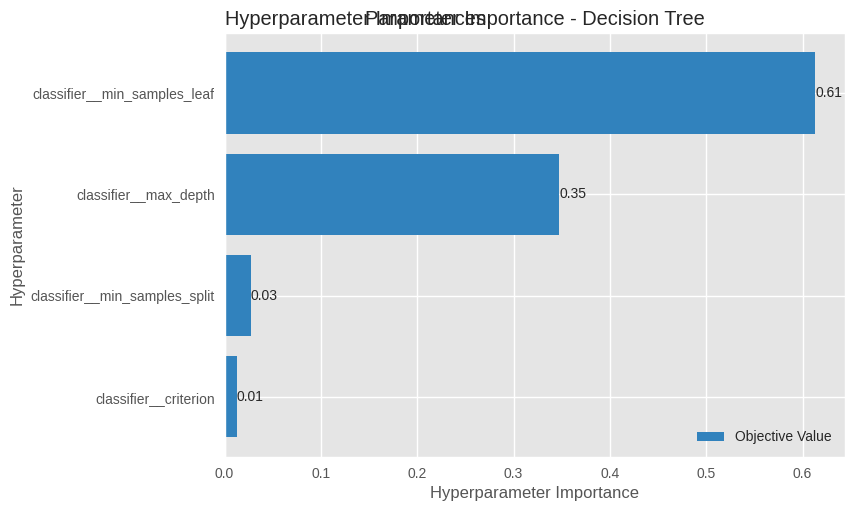

<ipython-input-272-2593032fb9bc>:27: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(knn_study)


<Figure size 1000x500 with 0 Axes>

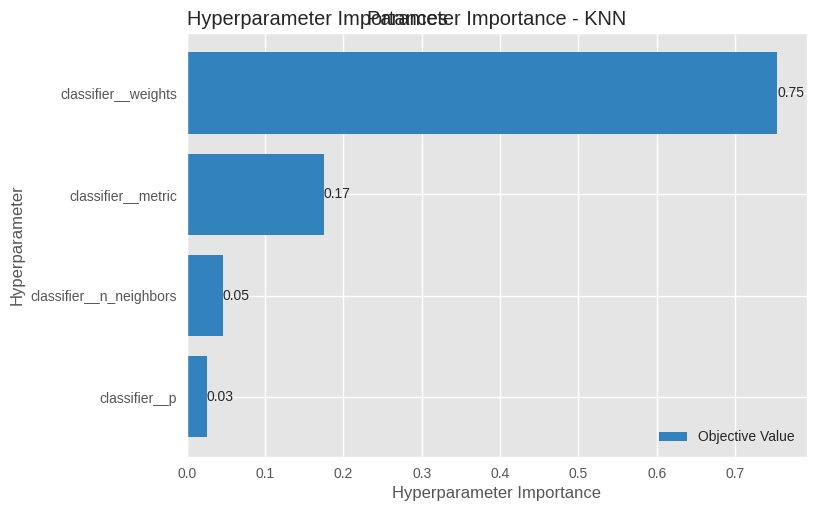

In [272]:
# Visualization of optimization history
dt_study = dt_optuna.study_
knn_study = knn_optuna.study_

# Plot optimization history for Decision Tree
plt.figure(figsize=(10, 5))
plot_optimization_history(dt_study)
plt.title("Optimization History - Decision Tree")
plt.show()

# Plot optimization history for KNN
plt.figure(figsize=(10, 5))
plot_optimization_history(knn_study)
plt.title("Optimization History - KNN")
plt.show()

# Additional visualization: Parameter importance

# Plot parameter importance for Decision Tree
plt.figure(figsize=(10, 5))
plot_param_importances(dt_study)
plt.title("Parameter Importance - Decision Tree")
plt.show()

# Plot parameter importance for KNN
plt.figure(figsize=(10, 5))
plot_param_importances(knn_study)
plt.title("Parameter Importance - KNN")
plt.show()

## Comparison Between the Searches
The following graphs were added for the reviewer's interest. They come from tutorial 3.

In [273]:
def create_model_comparison_summary(models_dict):
    # Create DataFrame from results
    data = {
        'Model': [],
        'Search Method': [],
        'Test Accuracy': []
    }

    for model_name, results in models_dict.items():
        data['Model'].append(model_name.split('_')[0])  # DT or KNN
        data['Search Method'].append(model_name.split('_')[1])  # Grid, Random, or Optuna
        data['Test Accuracy'].append(results['accuracy'])

    df = pd.DataFrame(data)

    # Add dummy classifier row if provided
    if 'Dummy' in models_dict:
        dummy_row = pd.DataFrame({
            'Model': ['Dummy Classifier'],
            'Search Method': ['N/A'],
            'Test Accuracy': [models_dict['Dummy']['accuracy']]
        })
        df = pd.concat([df, dummy_row], ignore_index=True)

    # Format accuracy as percentage
    df['Test Accuracy'] = df['Test Accuracy'].map('{:.1%}'.format)

    # Style the DataFrame
    styled_df = df.style\
        .set_properties(**{'text-align': 'center'})\
        .set_table_styles([
            {'selector': 'th',
             'props': [('text-align', 'center'),
                      ('font-weight', 'bold'),
                      ('background-color', '#000')]},
            {'selector': 'caption',
             'props': [('caption-side', 'top')]}
        ])\
        .set_caption('Model Performance Summary')\
        .hide(axis='index')

    return styled_df

# Collect all results
all_results = {
    'DT_Grid': {'accuracy': get_accuracy_on_test(best_dt_grid)},
    'DT_Random': {'accuracy': get_accuracy_on_test(best_dt_random)},
    'DT_Optuna': {'accuracy': get_accuracy_on_test(dt_optuna)},
    'KNN_Grid': {'accuracy': get_accuracy_on_test(best_knn_grid)},
    'KNN_Random': {'accuracy': get_accuracy_on_test(best_knn_random)},
    'KNN_Optuna': {'accuracy': get_accuracy_on_test(knn_optuna)},
}

# Display the summary table
from IPython.display import display
display(create_model_comparison_summary(all_results))

Model,Search Method,Test Accuracy
DT,Grid,82.4%
DT,Random,78.4%
DT,Optuna,88.2%
KNN,Grid,85.4%
KNN,Random,86.3%
KNN,Optuna,85.4%


## Summary
A summary of the results are shown in the table above. We can see that the Optuna search method produced the best results. This makes sense as the Optuna (Bayesian) method was given a high budget to find the best possible value. This accuracy of about 85% seems to be accurate enough without extremely overfitting the training set. This is the pessimistic estimate as well, so once the whole model is trained with the hyperparameters, the accuracy should get better and be able to generalize better. Notice, the Grid, Random, and Optuna models gave very similar values for the optimized hyperparameters.

In the upcoming section, the Optuna method will continue to be used since it gives the best accuracy and it the fastest search method in terms of time and compute.

# 4. ADVANCED METHODS

## Helper Functions

In [274]:

def train_default_advanced_model(name, model):
  default_accuracy = train_and_evaluate_model(name, model, X_train, y_train, X_test, y_test, add_time_to_global_flag=True)
  return default_accuracy

def train_optimized_advanced_model(name, model, params):
  optuna_search = OptunaSearchCV(
        model,
        params,
        n_trials=50,  # Number of trials
        cv=inner,
        random_state=random_state,
        timeout=600,  # 10 minutes timeout
        n_jobs=-1
    )
  optimized_accuracy = train_and_evaluate_model(name, optuna_search, X_train, y_train, X_test, y_test, add_time_to_global_flag=True)
  return optimized_accuracy

def visualize_comparison(default_results, optuna_results, title):
    # Prepare data for visualization
    accuracies = {
        f'Default {title}': default_results,
        f'Optimized {title}': optuna_results
    }

    # Create bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(accuracies.keys(), accuracies.values())

    # Customize plot
    plt.title(f'{title} Model Accuracy Comparison', pad=20)
    plt.ylabel('Accuracy Score')
    plt.ylim(0, 1)  # Set y-axis from 0 to 1

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    # Add grid for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

## Support Vector Classifier!

Training default SVM model...
Default SVM Accuracy: 0.804

Optimizing SVM with Optuna...


<ipython-input-274-f6a5667536b0>:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(


Optimized SVM Accuracy: 0.938
Best parameters: {'C': 71.74244939626712, 'gamma': 0.24925306132674754, 'kernel': 'rbf', 'degree': 7}

Creating visualization...


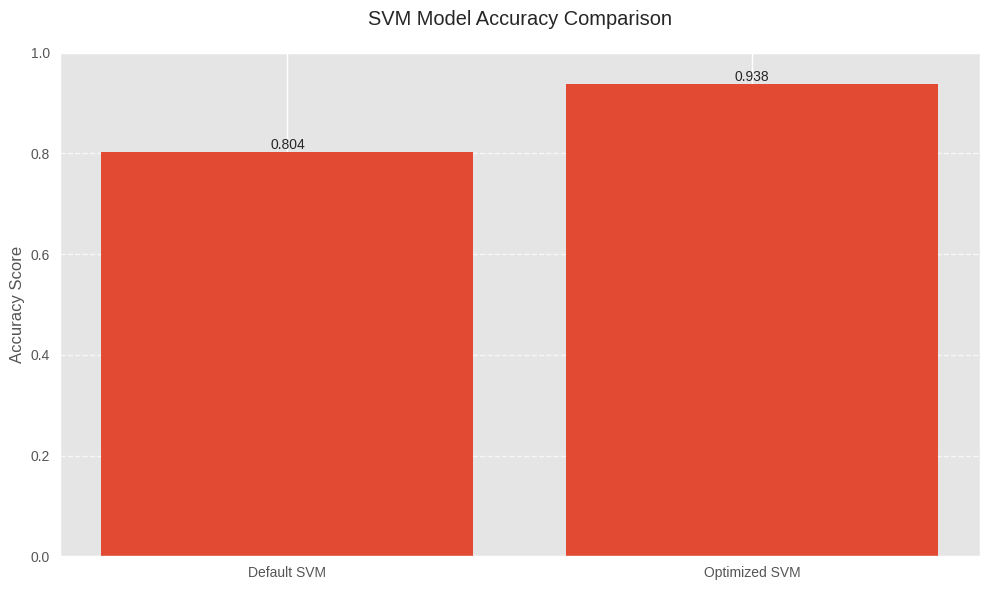

Visualization saved as 'svm_comparison.png'


In [275]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import optuna
import matplotlib.pyplot as plt
import seaborn as sns


# Train default model
print("Training default SVM model...")
default_results = train_default_advanced_model("SVM", SVC(random_state=random_state))
print(f"Default SVM Accuracy: {default_results:.3f}")

# Optimize model with Optuna
print("\nOptimizing SVM with Optuna...")
optuna_results = train_optimized_advanced_model(
    "SVM_optuna",
    SVC(random_state=random_state),
    {
        'C': optuna.distributions.FloatDistribution(0.1, 100, log=True),
        'gamma': optuna.distributions.FloatDistribution(0.1, 10, log=True),
        'kernel': optuna.distributions.CategoricalDistribution(['rbf', 'linear', 'poly']),
        'degree': optuna.distributions.IntDistribution(1, 7)
    })
print(f"Optimized SVM Accuracy: {optuna_results:.3f}")
print("Best parameters:",  fitted_pipelines["SVM_optuna"].named_steps["classifier"].best_params_)

# Create visualization
print("\nCreating visualization...")
visualize_comparison(default_results, optuna_results, "SVM")
print("Visualization saved as 'svm_comparison.png'")

#Update Global Vars
all_model_accuracies["SVM"] = default_results
all_model_accuracies["SVM_Optimized"] = optuna_results


Resource: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

## Random Forests

Training default Random Forest model...
Default Random Forest Accuracy: 0.927

Optimizing Random Forest with Optuna...


<ipython-input-274-f6a5667536b0>:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(


Optimized Random Forest Accuracy: 0.908
Best parameters: {'n_estimators': 371, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'entropy'}

Creating Random Forest visualization...


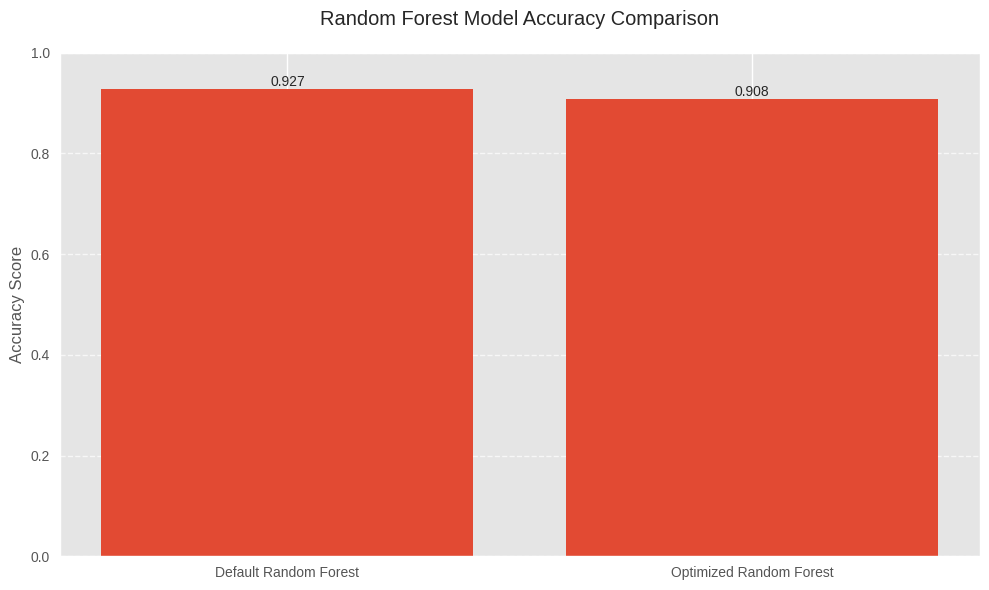

Visualization complete.


In [276]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Main execution flow for Random Forest
print("Training default Random Forest model...")
default_results = train_default_advanced_model("RF",  RandomForestClassifier(random_state=random_state))
print(f"Default Random Forest Accuracy: {default_results:.3f}")

print("\nOptimizing Random Forest with Optuna...")
optuna_results = train_optimized_advanced_model(
    "RF_optuna",
    RandomForestClassifier(random_state=random_state),
    {
        'n_estimators': optuna.distributions.IntDistribution(50, 500),  # Number of trees
        'max_depth': optuna.distributions.IntDistribution(5, 30),  # Tree depth
        'min_samples_split': optuna.distributions.IntDistribution(2, 20),  # Minimum samples to split a node
        'min_samples_leaf': optuna.distributions.IntDistribution(1, 20),  # Minimum samples per leaf
        'criterion': optuna.distributions.CategoricalDistribution(['gini', 'entropy'])  # Split criterion
    }
    )
print(f"Optimized Random Forest Accuracy: {optuna_results:.3f}")
print("Best parameters:", fitted_pipelines["RF_optuna"].named_steps["classifier"].best_params_)

# Create visualization
print("\nCreating Random Forest visualization...")
visualize_comparison(default_results, optuna_results, "Random Forest")
print("Visualization complete.")

#Update global Vars
all_model_accuracies["RF"] = default_results
all_model_accuracies["RF_Optimized"] = optuna_results


## Gradient Boosting

Training default Gradient Boosting model...
Default GB Accuracy: 0.832

Optimizing Gradient Boosting with Optuna...


<ipython-input-274-f6a5667536b0>:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(


Optimized GB Accuracy: 0.933
Best parameters: {'n_estimators': 204, 'learning_rate': 0.10155475406033973, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 1, 'subsample': 0.9446305268372862, 'max_features': 'log2'}

Creating visualization...


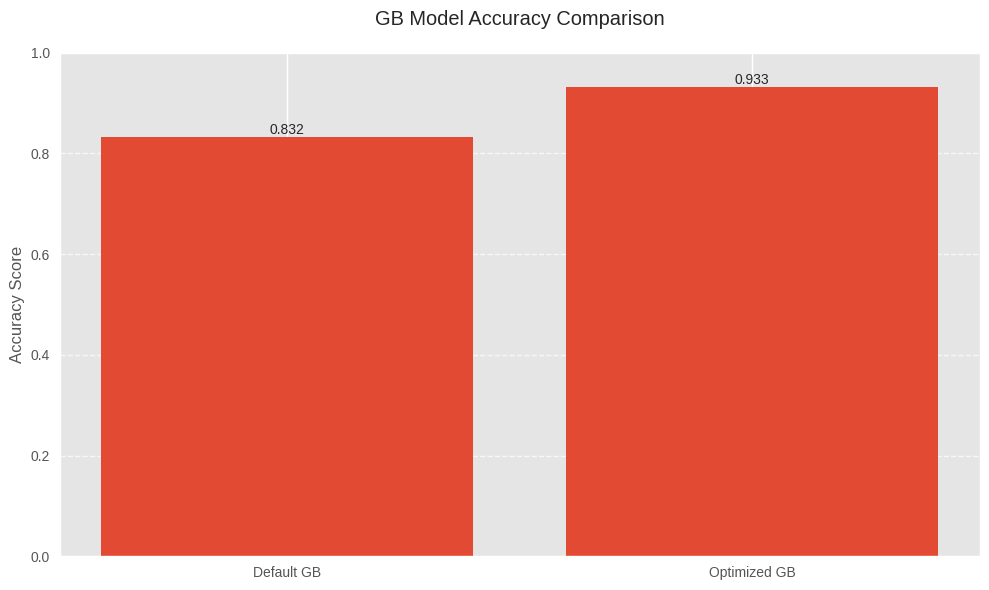

In [277]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import optuna
from optuna.integration import OptunaSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Train default model
print("Training default Gradient Boosting model...")
default_results = train_default_advanced_model("GB", GradientBoostingClassifier(random_state=random_state))
print(f"Default GB Accuracy: {default_results:.3f}")

# Optimize model with Optuna
print("\nOptimizing Gradient Boosting with Optuna...")
optuna_results = train_optimized_advanced_model(
    "GB_optuna",
    GradientBoostingClassifier(random_state=random_state),
    {
        'n_estimators': optuna.distributions.IntDistribution(50, 500),
        'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3, log=True),
        'max_depth': optuna.distributions.IntDistribution(3, 10),
        'min_samples_split': optuna.distributions.IntDistribution(2, 20),
        'min_samples_leaf': optuna.distributions.IntDistribution(1, 10),
        'subsample': optuna.distributions.FloatDistribution(0.5, 1.0),
        'max_features': optuna.distributions.CategoricalDistribution(['sqrt', 'log2', None])
    }
    )
print(f"Optimized GB Accuracy: {optuna_results:.3f}")
print("Best parameters:", fitted_pipelines["GB_optuna"].named_steps["classifier"].best_params_)

# Create visualization
print("\nCreating visualization...")
visualize_comparison(default_results, optuna_results, "GB")

#Update global Vars
all_model_accuracies["GB"] = default_results
all_model_accuracies["GB_Optimized"] = optuna_results

# 5. Results

## Comparison of All Models

In [296]:
# Create table with model accuracy rates and times
def calculate_confidence_intervals():
  for name, accuracy_score in all_model_accuracies.items():
    n_total = len(y_test)
    ci = stats.binom.interval(0.95, n_total, accuracy_score)
    ci_lower, ci_upper = ci[0]/n_total, ci[1]/n_total
    confidence_invervals[name] = (round(ci_lower, 3), round(ci_upper,3))

calculate_confidence_intervals()

def make_results_table():
  df = pd.DataFrame({
      'Model': list(all_model_accuracies.keys()),
      'Accuracy': list(all_model_accuracies.values()),
      '95% Confidence Interval': list(confidence_invervals.values()),
      'Time (s)': list(execution_times.values()),
  })

# Format the table
  styled_df = df.style\
    .format({'Accuracy': '{:.4f}', 'Time (s)': '{:.4f}'})\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'caption', 'props': [('caption-side', 'top')]}
    ])\
    .set_caption('Model Performance Comparison')\
    .hide(axis='index')

  display(styled_df)

make_results_table()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model,Accuracy,95% Confidence Interval,Time (s)
Decision Tree,0.8824,"(0.849, 0.916)",0.0721
KNN,0.7339,"(0.686, 0.779)",0.0526
Logistic Regression,0.7451,"(0.7, 0.79)",0.0551
DT_Optimized,0.8123,"(0.77, 0.852)",0.1035
KNN_Optimized,0.8543,"(0.818, 0.891)",0.0978
SVM,0.8039,"(0.762, 0.843)",67.3766
SVM_Optimized,0.9384,"(0.913, 0.961)",0.3232
RF,0.9272,"(0.899, 0.952)",182.6315
RF_Optimized,0.9076,"(0.877, 0.936)",0.5620
GB,0.8319,"(0.793, 0.871)",613.8427


## Isights
- It looks like the Basic models have the largest confidence intervals.
- As well, the advanced models have the best accuracy rates.
- The default SVM, RF, and GB took a long time to train.

To balance model performance and training time we will select the Optimized SVM to train the final model. This will be done below.

## Training the Final Model

In [310]:
X_comp_df = pd.read_pickle('/content/sample_data/attrition_compet_11.pkl')



final_svc = OptunaSearchCV(
        SVC(random_state=random_state),
        {
        'C': optuna.distributions.FloatDistribution(0.1, 100, log=True),
        'gamma': optuna.distributions.FloatDistribution(0.1, 10, log=True),
        'kernel': optuna.distributions.CategoricalDistribution(['rbf', 'linear', 'poly']),
        'degree': optuna.distributions.IntDistribution(1, 7)
    },
        n_trials=50,  # Number of trials
        cv=inner,
        random_state=random_state,
        timeout=600,  # 10 minutes timeout
        n_jobs=-1
    )

final_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', final_svc)])

final_pipe.fit(X,y)

final_predictions_comp = final_pipe.predict(X_comp_df)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-310-330e85890191>:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  final_svc = OptunaSearchCV(


In [312]:
from joblib import dump, load

# Save the final model to a file
dump(final_pipe, 'final_model.joblib')

# Load the model from the file
final_clf_reloaded = load('final_model.joblib')

dump(final_predictions_comp, 'final_predictions.csv')
predictions = load('final_predictions.csv')
print(predictions)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
